First pass on embeddings generated using all data 

In [114]:
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, auc
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.utils import to_categorical
tf.test.is_gpu_available()
os.chdir('/data/swamyvs/pacbio_testing/')

In [173]:

class SimpleDataObj:
    def __init__(self, x_mat_file, labels_file,kmer_size, one_label, zero_label, y_format='tf'):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=Y_labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        Y_vec=np.asarray(X_df_labeled['target_label'])
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec
        if y_format == 'tf':
            X_train, self.X_val, Y_train_labs, Y_val_labs= train_test_split(X_data,labs,test_size=.2, random_state=42, stratify=Y_vec)
            self.Y_val=to_categorical(Y_val_labs['target_label'])
            self.Y_val_labs=np.asarray(Y_val_labs['intersection_case'])
            self.X_train, self.X_test, Y_train_labs, Y_test_labs=train_test_split(X_train,Y_train_labs,test_size=.2, 
                                                                                  random_state=42,stratify=Y_train_labs['intersection_case'])
            self.Y_train=to_categorical(Y_train_labs['target_label'])
            self.Y_train_labs=np.asarray(Y_train_labs['intersection_case'])
            self.Y_test=to_categorical(Y_test_labs['target_label'])
            self.Y_test_labs=np.asarray(Y_test_labs['intersection_case'])

        else:
            X_train, self.X_val, Y_train_labs, Y_val_labs= train_test_split(X_data,labs,test_size=.2, random_state=42, stratify=Y_vec)
            self.Y_val=np.asarray(Y_val_labs['target_label'])
            self.Y_val_labs=np.asarray(Y_val_labs['intersection_case'])
            self.X_train, self.X_test, Y_train_labs, Y_test_labs=train_test_split(X_train,Y_train_labs,test_size=.2, 
                                                                                  random_state=42,stratify=Y_train_labs['intersection_case'])
            self.Y_train=np.asarray(Y_train_labs['target_label'])
            self.Y_train_labs=np.asarray(Y_train_labs['intersection_case'])
            self.Y_test=np.asarray(Y_test_labs['target_label'])
            self.Y_test_labs=np.asarray(Y_test_labs['intersection_case'])
            
        self.y_format=y_format
        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')



In [295]:
dat=SimpleDataObj('data/embeddings_v1_all_tx//embedded_model_data/all_RPE_loose_kmers_10_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'transcript',
                  'not_transcript',
                  'sk'
                 )


In [272]:
dat.summary()

Training size: 384678
validation size: 120213
testing size: 96170
transcript count: 198277
not_transcript count : 402784


In [61]:
np.count_nonzero(dat.Y_train == 1) / np.count_nonzero(dat.Y_train == 0)
np.count_nonzero(dat.Y_val == 1) / np.count_nonzero(dat.Y_val == 0)
np.count_nonzero(dat.Y_test == 1) / np.count_nonzero(dat.Y_test == 0)


0.4922570834497098

In [100]:
pca=PCA(n_components=2)
pca.fit(dat.X_train)
dff=pd.DataFrame(data=pca.transform(dat.X_train), index=None, columns=['P1', 'P2']).assign(lab=np.where(dat.Y_train == 1, 'transcript', 'not_transcript'),
                                                                                          intersection_case = dat.Y_train_labs)

In [90]:
dff

,P1,P2,lab
0,-0.983413,0.311964,not_transcript
1,-0.511589,0.124708,not_transcript
2,-0.493566,0.113453,transcript
3,0.834994,0.048811,transcript
4,-0.443024,0.263013,transcript
...,...,...,...
384673,-0.742597,-0.232968,not_transcript
384674,0.547032,-0.080587,not_transcript
384675,-0.550955,-0.287279,not_transcript
384676,-0.906959,0.156099,not_transcript


In [84]:
import plotnine as pn

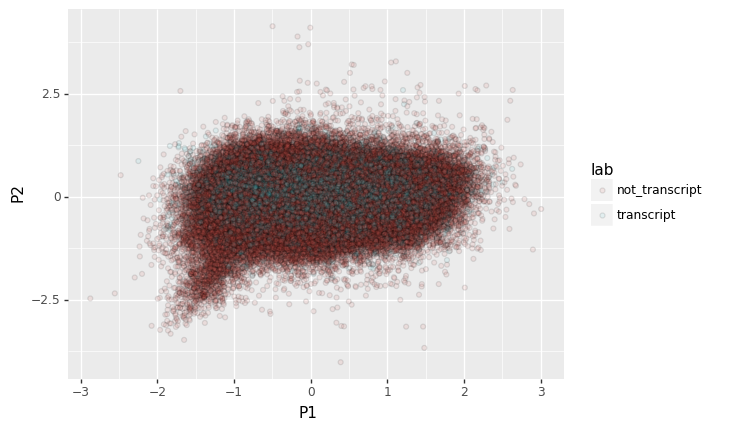

<ggplot: (2932603035221)>

In [91]:
(pn.ggplot(dff, pn.aes(x='P1', y='P2', fill='lab')) +
    pn.geom_point(alpha=.1))

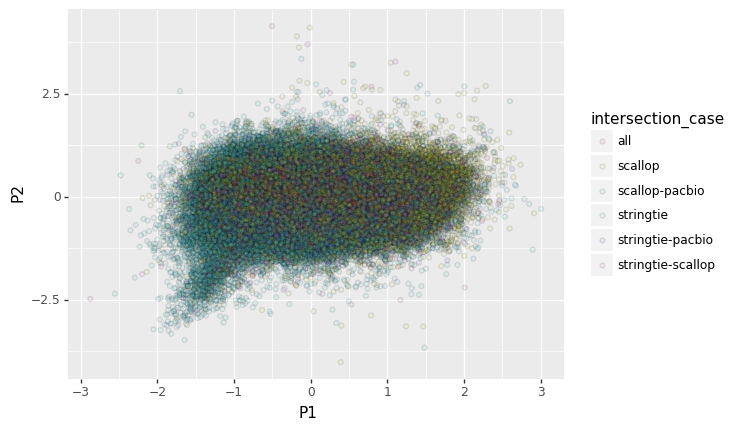

<ggplot: (2932681963545)>

In [101]:
(pn.ggplot(dff, pn.aes(x='P1', y='P2', fill='intersection_case')) +
    pn.geom_point(alpha=.1))

/data/swamyvs/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [298]:


def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    AUC = auc(rec, pre)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()  
def model_results(obj, model):
    X_train=obj.X_train
    Y_train=obj.Y_train
    X_test=obj.X_test
    Y_test=obj.Y_test
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    labs=model.classes_
    print('confusion matrix\n\n')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=labs, columns=labs))
    print('\n\nclassification report\n\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    ROC_plot(Y_test , Y_prob)
    PR_plot(Y_test,Y_prob)
    return(model)

In [296]:
rfmodel=RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=32)
rfmodel.fit(dat.X_train, dat.Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

confusion matrix


       0      1
0  59213   5232
1  21292  10433


classification report


              precision    recall  f1-score   support

           0       0.74      0.92      0.82     64445
           1       0.67      0.33      0.44     31725

    accuracy                           0.72     96170
   macro avg       0.70      0.62      0.63     96170
weighted avg       0.71      0.72      0.69     96170



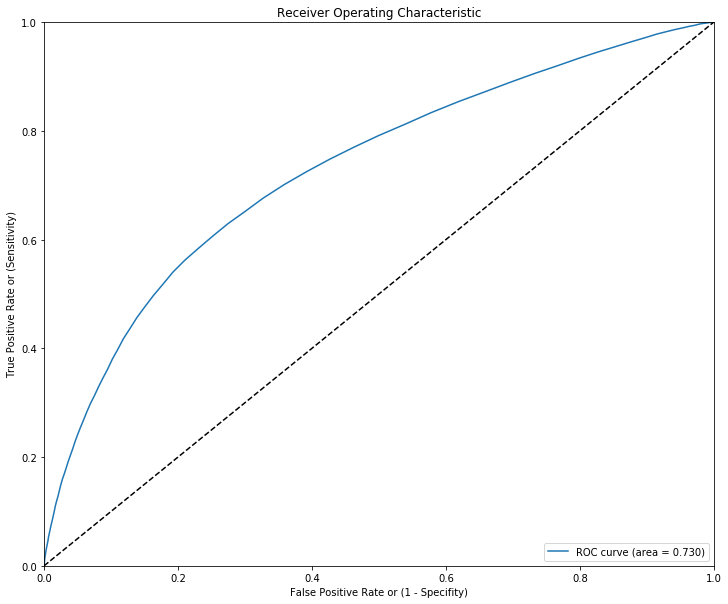

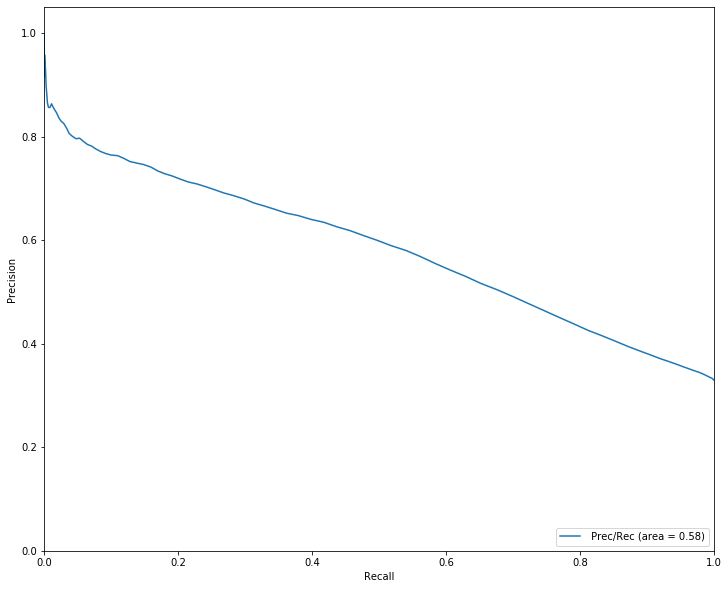

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [299]:
model_results(dat, rfmodel)

so not great, but its some what better than nothing

In [292]:
dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_8_dims-100.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    100,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )

FileNotFoundError: [Errno 2] No such file or directory: 'data/embedded_model_data/all_RPE_loose_kmers_10_dims-300.csv.gz'

In [157]:

MAX_TRAIN_SIZE=len(dat_tf.X_train) +1
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]



def plot_metrics(history):
    metrics =  ['loss', 'auc', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,1,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        else:
            plt.ylim([0,1])

        plt.legend()

def model_results(model, data):
    pred=[p[1] for p in  model.predict(data.X_test)]
    pred_class = np.int64([p > .5 for p in pred])
    true_class=[i[1] for i in data.Y_test]
    ROC_plot(true_class, pred)
    PR_plot(true_class, pred)
    labs=[data.zero_label, data.one_label] 
    print(pd.DataFrame(confusion_matrix(true_class, pred_class), index=labs, columns=labs))
    print(classification_report(pred_class,true_class))
 
    


def train_dense_model(obj):
    model=keras.Sequential()
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=200, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)



In [137]:
hist, model= train_dense_model(dat_tf)

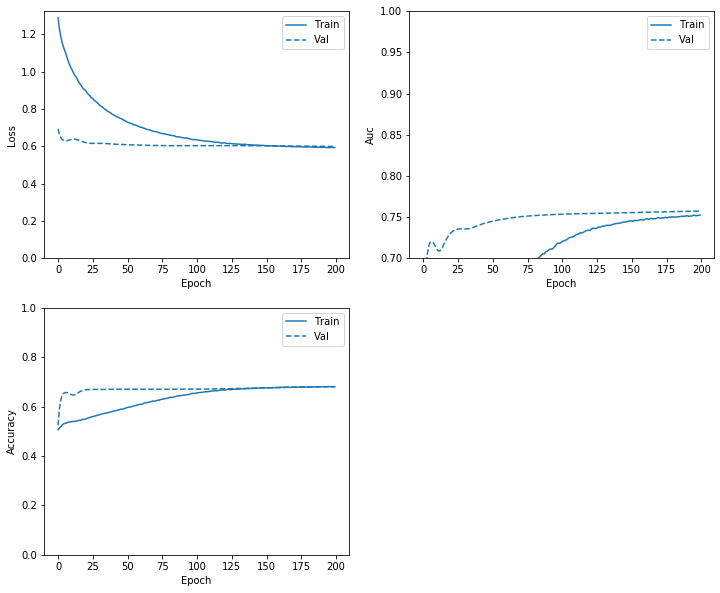

In [139]:
plot_metrics(hist)

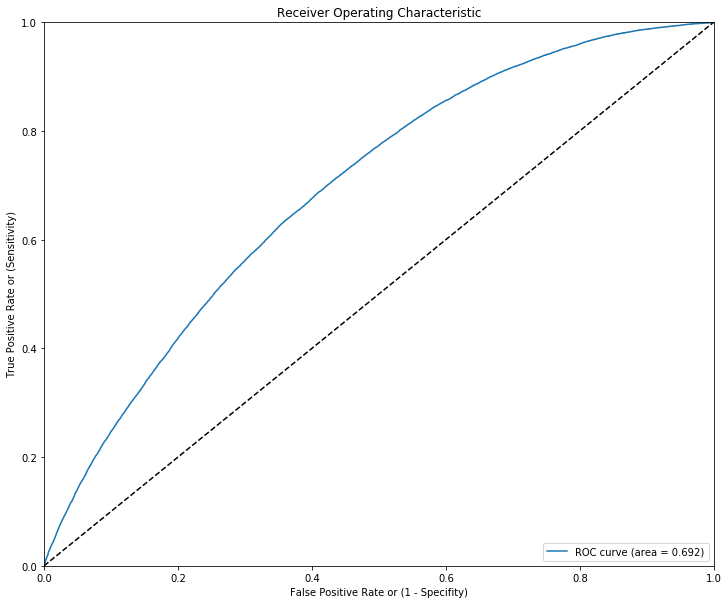

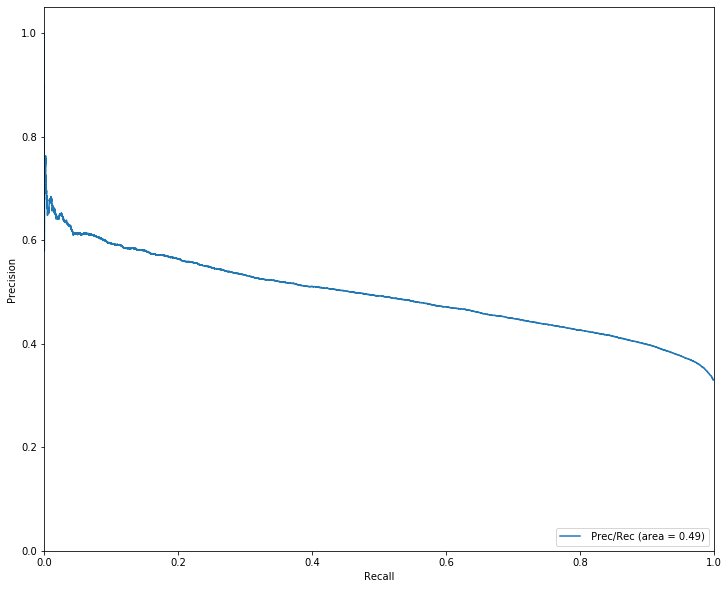

                not_transcript  transcript
not_transcript           62555        1890
transcript               28891        2834
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     91446
           1       0.09      0.60      0.16      4724

    accuracy                           0.68     96170
   macro avg       0.53      0.64      0.48     96170
weighted avg       0.93      0.68      0.77     96170



In [146]:
model_results(model, dat_tf)

In [148]:
def train_dense_model(obj):
    model=keras.Sequential()
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(200,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(10,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=200, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)

In [149]:
hist2, model2= train_dense_model(dat_tf)

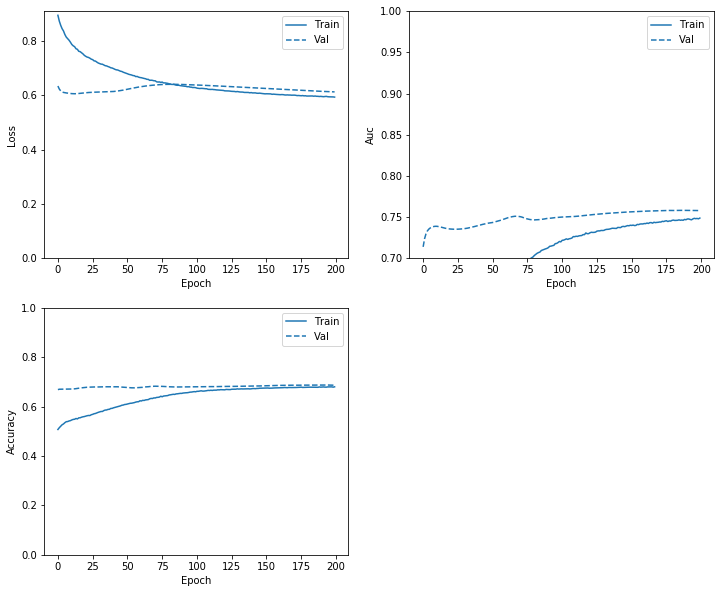

In [150]:
plot_metrics(hist2)

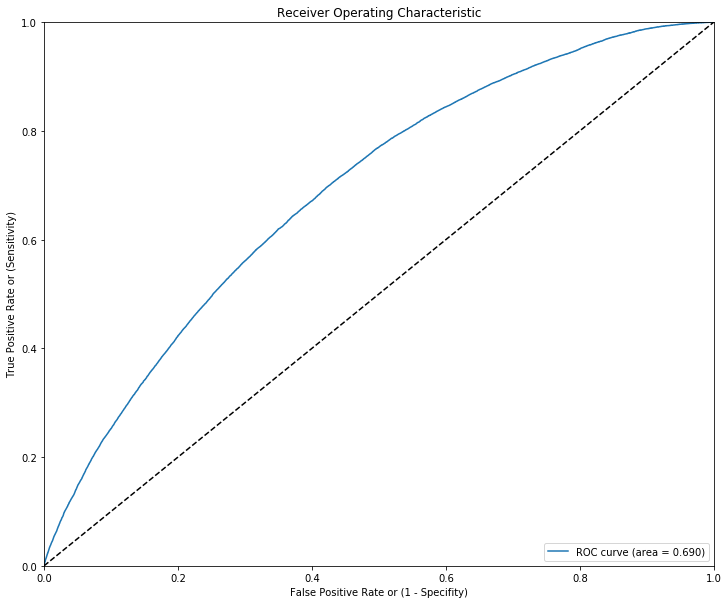

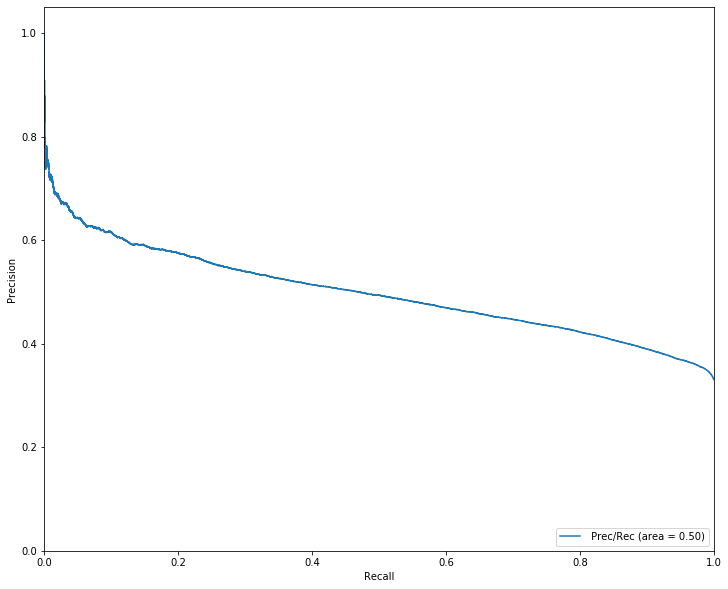

                not_transcript  transcript
not_transcript           60703        3742
transcript               26476        5249
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     87179
           1       0.17      0.58      0.26      8991

    accuracy                           0.69     96170
   macro avg       0.55      0.64      0.53     96170
weighted avg       0.87      0.69      0.75     96170



In [152]:
model_results(model2, dat_tf)

In [170]:
def run_all(model, data, plot_title):
    history, model = model(data)
    metrics =  ['loss', 'auc', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    pred=[p[1] for p in  model.predict(data.X_test)]
    pred_class = np.int64([p > .5 for p in pred])
    true_class=[i[1] for i in data.Y_test]
    
    fpr, tpr, thresholds=roc_curve(true_class, pred)
    AUC=roc_auc_score(true_class, pred)
    # Plot ROC curve
    plt.subplot(2,3,4)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
   
    pre, rec, thresholds = precision_recall_curve(true_class, pred)
    AUC = auc(rec, pre)
    plt.subplot(2,3,5)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall plot')
    plt.legend(loc="lower right")
    
    
    plt.suptitle(plot_title)
    plt.show()
    labs=[data.zero_label, data.one_label] 
    print(pd.DataFrame(confusion_matrix(true_class, pred_class), index=labs, columns=labs))
    print(classification_report(pred_class,true_class))
    return history, model 

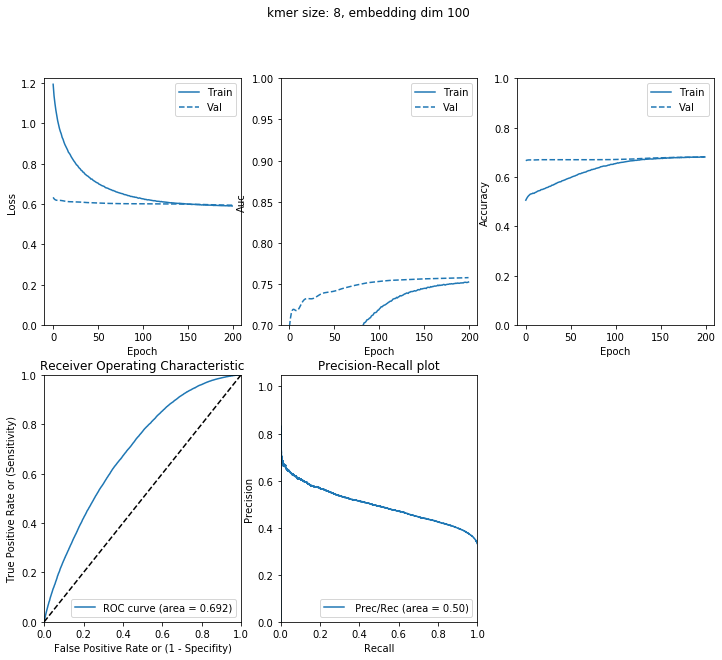

                not_transcript  transcript
not_transcript           62520        1925
transcript               28735        2990
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     91255
           1       0.09      0.61      0.16      4915

    accuracy                           0.68     96170
   macro avg       0.53      0.65      0.48     96170
weighted avg       0.93      0.68      0.77     96170



In [171]:
k8d100=dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_8_dims-100.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                  'transcript',
                  'not_transcript',
                  'tf'
                 )
k8d100_hist, k8d100_model =  run_all(train_dense_model, k8d100, 'kmer size: 8, embedding dim 100')


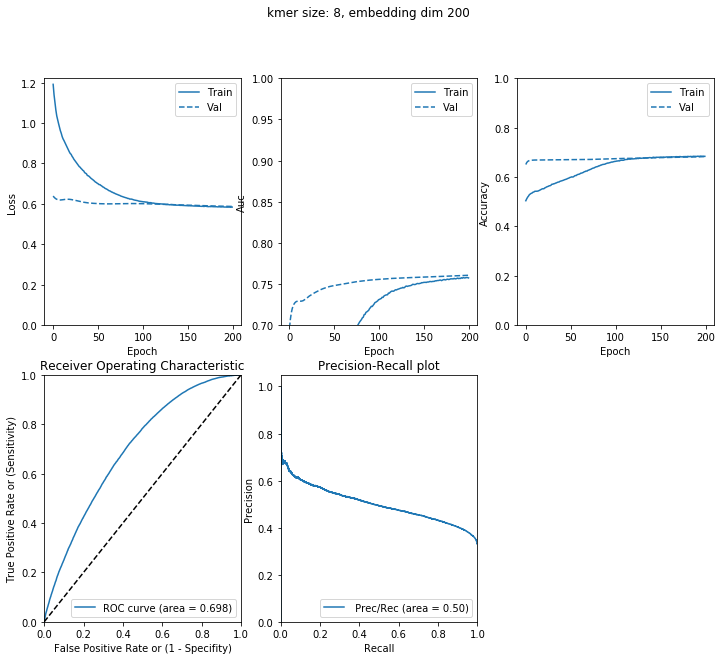

                not_transcript  transcript
not_transcript           62339        2106
transcript               28517        3208
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     90856
           1       0.10      0.60      0.17      5314

    accuracy                           0.68     96170
   macro avg       0.53      0.64      0.49     96170
weighted avg       0.92      0.68      0.77     96170



In [175]:
k8d200=dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_8_dims-200.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    200,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )
k8d200_hist, k8d200_model =  run_all(train_dense_model, k8d200, 'kmer size: 8, embedding dim 200')

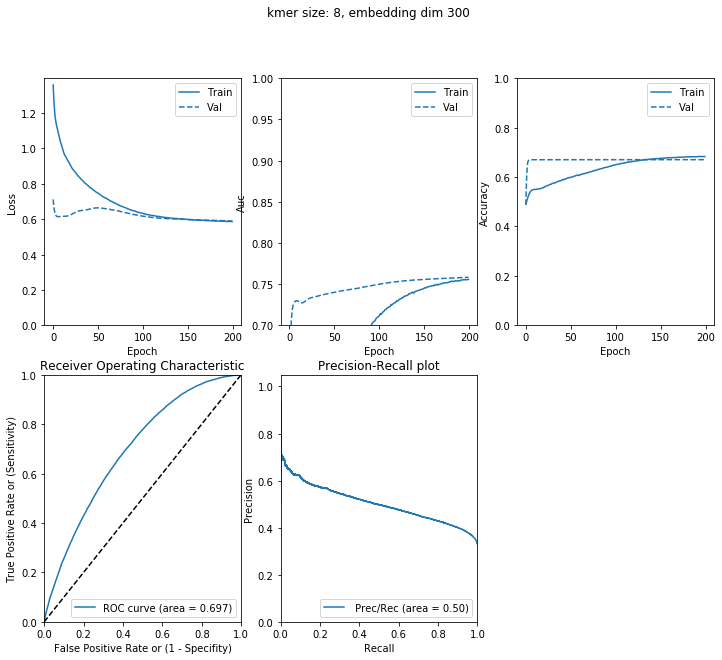

                not_transcript  transcript
not_transcript           64443           2
transcript               31703          22
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     96146
           1       0.00      0.92      0.00        24

    accuracy                           0.67     96170
   macro avg       0.50      0.79      0.40     96170
weighted avg       1.00      0.67      0.80     96170



In [176]:
k8d300=dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_8_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    300,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )
k8d300_hist, k8d300_model =  run_all(train_dense_model, k8d300, 'kmer size: 8, embedding dim 300')

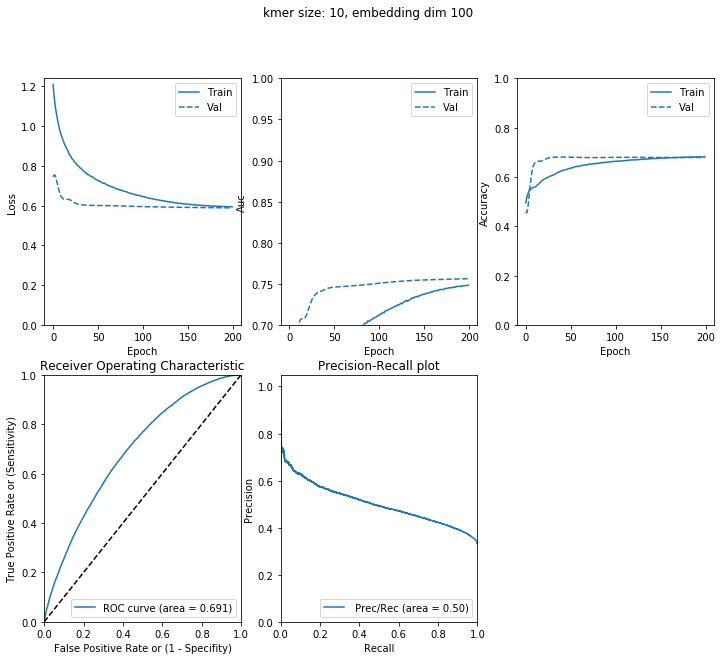

                not_transcript  transcript
not_transcript           63244        1201
transcript               29575        2150
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     92819
           1       0.07      0.64      0.12      3351

    accuracy                           0.68     96170
   macro avg       0.52      0.66      0.46     96170
weighted avg       0.95      0.68      0.78     96170



In [177]:
k10d100=dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_10_dims-100.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    100,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )
k10d100_hist, k10d100_model =  run_all(train_dense_model, k10d100, 'kmer size: 10, embedding dim 100')

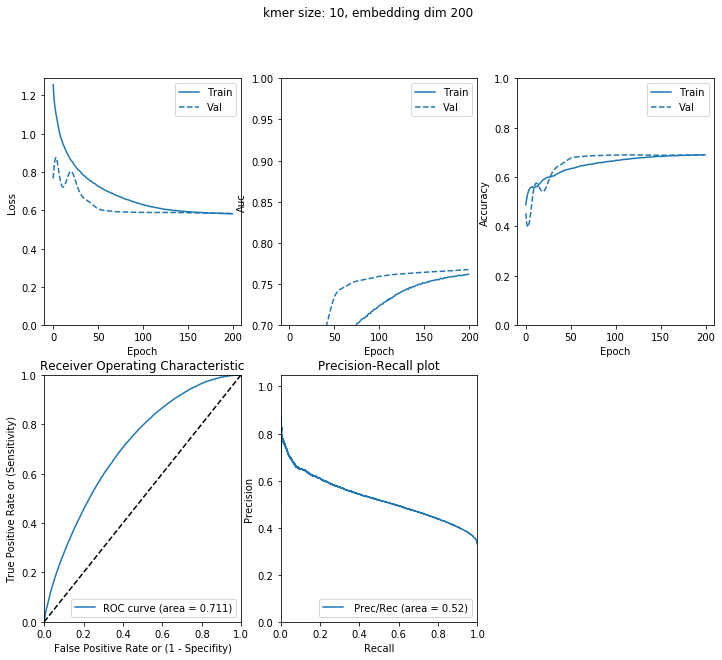

                not_transcript  transcript
not_transcript           60980        3465
transcript               26110        5615
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     87090
           1       0.18      0.62      0.28      9080

    accuracy                           0.69     96170
   macro avg       0.56      0.66      0.54     96170
weighted avg       0.87      0.69      0.75     96170



In [178]:
k10d200=dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_10_dims-200.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    200,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )
k10d200_hist, k10d200_model =  run_all(train_dense_model, k10d200, 'kmer size: 10, embedding dim 200')

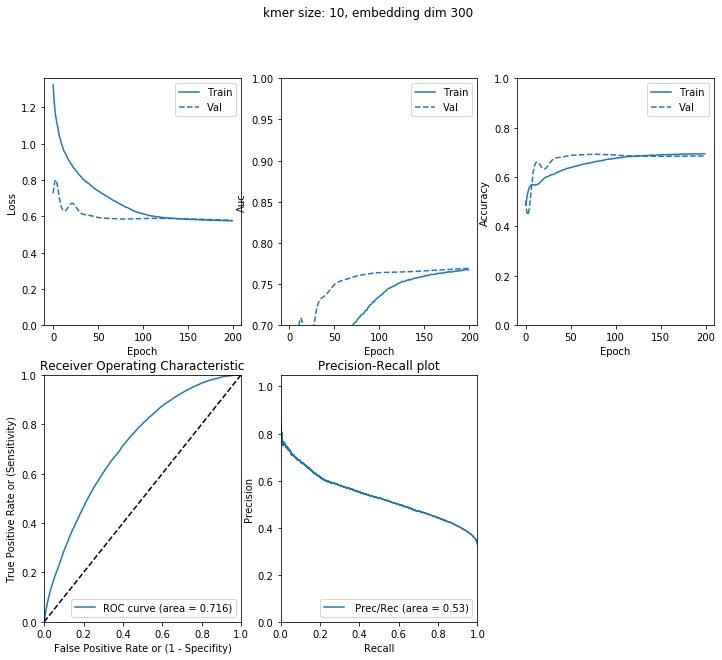

                not_transcript  transcript
not_transcript           63042        1403
transcript               28649        3076
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     91691
           1       0.10      0.69      0.17      4479

    accuracy                           0.69     96170
   macro avg       0.54      0.69      0.49     96170
weighted avg       0.94      0.69      0.78     96170



In [180]:
k10d300=dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_10_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    300,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )
k10d300_hist, k10d300_model =  run_all(train_dense_model, k10d300, 'kmer size: 10, embedding dim 300')

In [181]:
positive_cases

['all', 'stringtie-pacbio', 'scallop-pacbio']

In [191]:
class RnnDataObj:
    def __init__(self, x_mat_file, labels_file,kmer_size,block_size, one_label, zero_label):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        
        assert X_data.shape[1] % block_size == 0
        block_dim=int(X_data.shape[1] / block_size)
        X_data=np.asarray( [vec.reshape(block_size, block_dim) for vec in X_data])
        Y_vec=np.asarray(X_df_labeled['target_label'])
        
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec

        X_train, self.X_val, Y_train_labs, Y_val_labs= train_test_split(X_data,labs,test_size=.2, random_state=42, stratify=Y_vec)
        self.Y_val=to_categorical(Y_val_labs['target_label'])
        self.Y_val_labs=np.asarray(Y_val_labs['intersection_case'])
        self.X_train, self.X_test, Y_train_labs, Y_test_labs=train_test_split(X_train,Y_train_labs,test_size=.2, 
                                                                              random_state=42,stratify=Y_train_labs['intersection_case'])
        self.Y_train=to_categorical(Y_train_labs['target_label'])
        self.Y_train_labs=np.asarray(Y_train_labs['intersection_case'])
        self.Y_test=to_categorical(Y_test_labs['target_label'])
        self.Y_test_labs=np.asarray(Y_test_labs['intersection_case'])

        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')

In [210]:
dat_rnn=RnnDataObj('data/embedded_model_data/all_RPE_loose_kmers_10_dims-100.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    100,
                    10,
                  'transcript',
                  'not_transcript',
                 )

In [195]:
dat_rnn.X_train.shape

(384678, 10, 10)

In [204]:
def LSTM_dense_model(obj, batch_n=128, nepochs=300):
    NUM_UNITS=150
    MAX_TRAIN_SIZE=int(obj.X_train.shape[0] / batch_n)
    DIM=obj.X_train.shape[1:]
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=DIM))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=NUM_UNITS)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=nepochs, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)

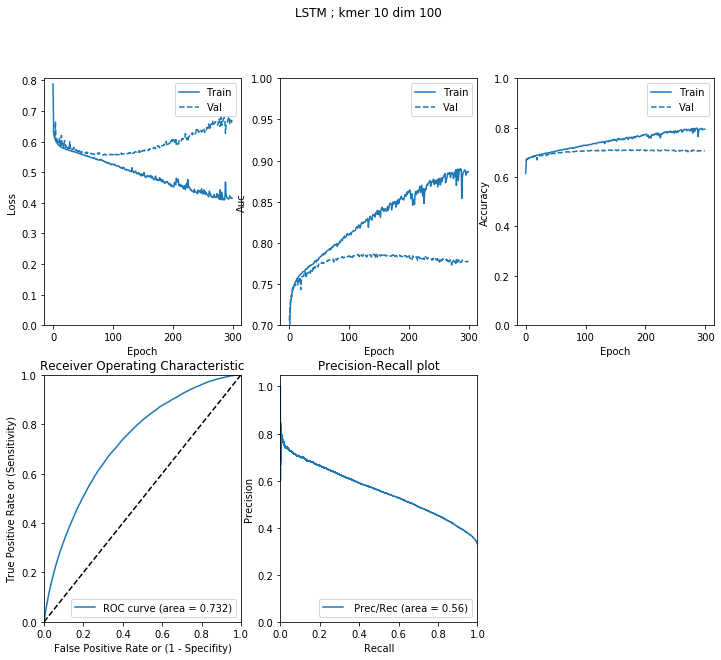

                not_transcript  transcript
not_transcript           53526       10919
transcript               17140       14585
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     70666
           1       0.46      0.57      0.51     25504

    accuracy                           0.71     96170
   macro avg       0.65      0.66      0.65     96170
weighted avg       0.73      0.71      0.72     96170



In [205]:
rhist, rmodel = run_all(LSTM_dense_model, dat_rnn, 'LSTM ; kmer 10 dim 100')

In [206]:
rnn_k10d300=RnnDataObj('data/embedded_model_data/all_RPE_loose_kmers_10_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                    300,
                    10,
                  'transcript',
                  'not_transcript',
                 )


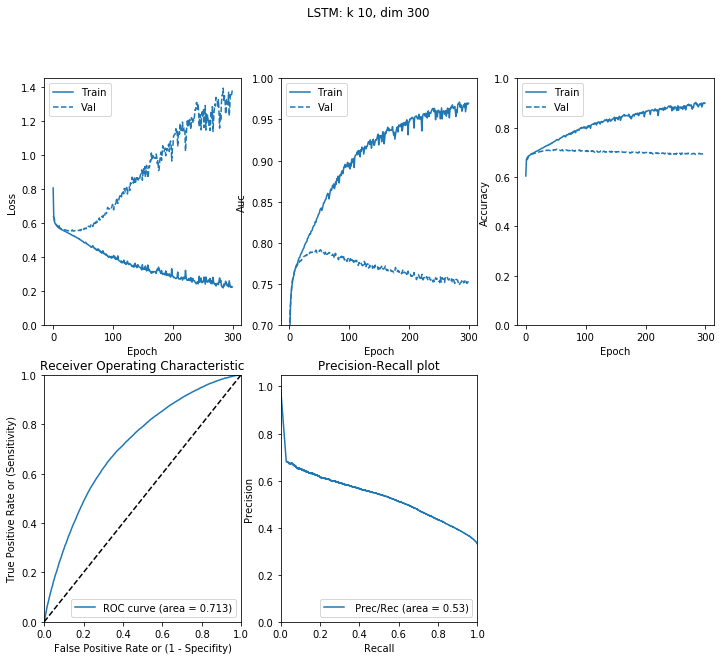

                not_transcript  transcript
not_transcript           51268       13177
transcript               16014       15711
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     67282
           1       0.50      0.54      0.52     28888

    accuracy                           0.70     96170
   macro avg       0.65      0.65      0.65     96170
weighted avg       0.71      0.70      0.70     96170



In [209]:
rnn_k10d300_hist, rnn_k10d300_model = run_all(LSTM_dense_model, rnn_k10d300, 'LSTM: k 10, dim 300')

In [251]:
def extract_intersection_cases(model, data):
    pred=np.asarray([p[1] for p in  model.predict(data.X_test)])
    pred_class = np.int64([p > .5 for p in pred])
    true_class=np.asarray([i[1] for i in data.Y_test])
    pred_cor= true_class == pred_class
    pred_fal= true_class != pred_class
    pred_true_probs=pred[pred_cor]
    pred_true_labels = data.Y_test_labs[pred_cor]
    pred_false_probs = pred[pred_fal]
    pred_false_labels = data.Y_test_labs[pred_fal]
    
    return pd.DataFrame({'probs':pred_true_probs, 'labs':pred_true_labels}, index=None), pd.DataFrame({'probs':pred_false_probs, 'labs':pred_false_labels}, index=None)
    
    
    

In [252]:
right, wrong=extract_intersection_cases(rnn_k10d300_model,rnn_k10d300)

In [254]:
right['probs'].describe()

count    66979.000000
mean         0.259864
std          0.359251
min          0.000000
25%          0.000018
50%          0.030695
75%          0.452931
max          1.000000
Name: probs, dtype: float64

In [255]:
wrong['probs']

count    2.919100e+04
mean     4.481492e-01
std      3.771757e-01
min      7.845781e-35
25%      3.749301e-02
50%      4.152239e-01
75%      8.256163e-01
max      1.000000e+00
Name: probs, dtype: float64

In [261]:
positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
fake_transcript_called_true=wrong[~wrong['labs'].isin(positive_cases)]
true_transcript_called_fake=wrong[wrong['labs'].isin(positive_cases)]

In [264]:
fake_transcript_called_true.probs.describe()

count    13177.000000
mean         0.823730
std          0.165684
min          0.500006
25%          0.677539
50%          0.865541
75%          0.988505
max          1.000000
Name: probs, dtype: float64

In [265]:
fake_transcript_called_true.labs.value_counts()

scallop              7291
stringtie            4441
stringtie-scallop    1445
Name: labs, dtype: int64

In [267]:
true_transcript_called_fake.probs.describe()

count    1.601400e+04
mean     1.391087e-01
std      1.585836e-01
min      7.845781e-35
25%      8.243879e-04
50%      6.027422e-02
75%      2.610982e-01
max      4.999790e-01
Name: probs, dtype: float64

In [268]:
true_transcript_called_fake.labs.value_counts()

stringtie-pacbio    8030
all                 5020
scallop-pacbio      2964
Name: labs, dtype: int64

In [269]:
dat_tf.summary()

Training size: 384678
validation size: 120213
testing size: 96170
transcript count: 198277
not_transcript count : 402784


In [278]:
right, wrong=extract_intersection_cases(rnn_k10d300_model,rnn_k10d300)
right.to_csv('testing/rnn_k10d300_right.csv', index=False)
wrong.to_csv('testing/rnn_k10d300_wrong.csv', index=False)

In [279]:
right, wrong=extract_intersection_cases(k10d300_model,k10d300)
right.to_csv('testing/k10d300_right.csv', index=False)
wrong.to_csv('testing/k10d300_wrong.csv', index=False)

In [290]:
def extract_intersection_cases_skl(model, data):
    pred_class=model.predict(data.X_test)
    pred=model.predict_proba(data.X_test)[:,1]
    true_class=np.asarray(data.Y_test)
    pred_cor= true_class == pred_class
    pred_fal= true_class != pred_class
    pred_true_probs=pred[pred_cor]
    pred_true_labels = data.Y_test_labs[pred_cor]
    pred_false_probs = pred[pred_fal]
    pred_false_labels = data.Y_test_labs[pred_fal]
    return pd.DataFrame({'probs':pred_true_probs, 'labs':pred_true_labels}, index=None), pd.DataFrame({'probs':pred_false_probs, 'labs':pred_false_labels}, index=None)

In [300]:
right, wrong=extract_intersection_cases_skl(rfmodel,dat)
right.to_csv('testing/rf_right.csv', index=False)
wrong.to_csv('testing/rf_wrong.csv', index=False)